# Biodata Mahasiswa
## Praktikum Pekan 10 : Klasifikasi & Regresi menggunakan Model Neural Network (NN) pada IMDB Dataset

VSI2J3 - Dasar Ilmu Data

NIM: 607012300120

Nama: Ilham Setiawan Siregar

Kelas: D3SI-47-04

# Deskripsi contoh

Colab berikut merupakan contoh untuk memprediksi sentimen (positif/negatif) dari ulasan film berdasarkan teks ulasan. Prediksi akan dilakukan dengan cara klasifikasi, yang dapat dilakukan dengan 1 method, yaitu:
1. Klasifikasi (Classification). Klasifikasi yang akan digunakan pada colab ini adalah Neural Network (NN).

* Prediksi didasarkan pada dua kategori, yaitu: ```positive``` dan ```negative```.
* Dataset akan diambil dari dataset ```IMDB Dataset.csv```
* Dataset tersebut memiliki 1 fitur dan 1 label.
* Fiturnya adalah review.
  - review adalah teks ulasan dari kritikus film.

# Tahapan code untuk persiapan data
1. Koneksi colab dengan GDrive
2. Tampilkan isi folder dataset_ilmu_data
3. Import library yang dibutuhkan
4. Load dataset
5. Tampilkan contoh data

## Koneksi colab dengan GDrive





In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Import the necessary libraries again
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import tensorflow as tf
seaborn.set(style='ticks')
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import re

## Load dataset

In [ ]:
#load data google drive
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv')
print (df.shape)

(50000, 2)


## Tampilkan contoh data

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Pemeriksaan missing values atau duplikasi dalam dataset

In [ ]:
# 1. Pemeriksaan Missing Values
print("=== PEMERIKSAAN MISSING VALUES ===")
print("Jumlah missing values per kolom:")
print(df.isnull().sum())

print("\nPersentase missing values per kolom:")
print(df.isnull().mean() * 100)

# 2. Pemeriksaan Data Duplikat
print("\n=== PEMERIKSAAN DATA DUPLIKAT ===")
jumlah_duplikat = df.duplicated().sum()
print(f"Jumlah baris duplikat: {jumlah_duplikat}")

# Jika ada duplikasi, kita bisa hapus duplikat seperti ini:
if jumlah_duplikat > 0:
    df = df.drop_duplicates()
    print(f"Setelah menghapus duplikat, jumlah data menjadi: {len(df)}")

# Menampilkan dimensi akhir dataset
print("\nDimensi dataset setelah pemeriksaan:")
print(df.shape)

=== PEMERIKSAAN MISSING VALUES ===
Jumlah missing values per kolom:
review       0
sentiment    0
dtype: int64

Persentase missing values per kolom:
review       0.0
sentiment    0.0
dtype: float64

=== PEMERIKSAAN DATA DUPLIKAT ===
Jumlah baris duplikat: 418
Setelah menghapus duplikat, jumlah data menjadi: 49582

Dimensi dataset setelah pemeriksaan:
(49582, 2)


# Klasifikasi menggunakan NN



### 1) Pilih fitur yang akan digunakan

Tahap ini sama dengan code di classification, yaitu memilih fitur dari dataset.

In [ ]:
# 1. Pilih fitur (review) dan label (sentimen)
X = df['review']    # Fitur teks
y = df['sentiment']  # Target label

# 2. Encode label menjadi nilai numerik: misalnya 'negative'=0, 'positive'=1
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Simpan mapping label untuk referensi nanti
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping label:", label_mapping)

# Menampilkan beberapa contoh hasil encoding
print("\nContoh label sebelum & sesudah encoding:")
for original, encoded in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original} => {encoded}")

Mapping label: {'negative': np.int64(0), 'positive': np.int64(1)}

Contoh label sebelum & sesudah encoding:
negative => 0
positive => 1


### 2) Lakukan pre-processing (jika diperlukan)

In [ ]:
# 3. Fungsi cleaning teks
def clean_text(text):
    text = re.sub(r'<[^>]+>', ' ', text)                 # Hapus HTML tags
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)              # Hanya huruf, sisanya diganti spasi
    text = text.lower().strip()                           # Lowercase dan hapus spasi ekstra
    text = re.sub(r'\s+', ' ', text)                      # Samakan banyak spasi jadi satu
    return text

# 4. Terapkan cleaning pada seluruh kolom review
X_cleaned = X.apply(clean_text)

# 5. Tokenisasi
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_cleaned)
sequences = tokenizer.texts_to_sequences(X_cleaned)
padded = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

# 6. Bagi dataset menjadi train dan test (Dilakukan sebelumnya, ulang pembagian untuk mendapatkan raw text test set)
# Gunakan indeks yang sama dari pembagian padded data untuk mendapatkan teks mentah yang sesuai
_, X_test_raw, _, _ = train_test_split(X_cleaned, y, test_size=0.3, random_state=42, stratify=y)

# Tampilkan info hasil preprocessing
print("Contoh teks sebelum dan sesudah cleaning:")
for i in range(2):
    print(f"\nOriginal:\n{X.iloc[i]}")
    print(f"Cleaned:\n{X_cleaned.iloc[i]}")

print("\nDimensi data setelah tokenisasi dan padding:", padded.shape)
print("\nDimensi X_test_raw:", X_test_raw.shape) # Tambahkan ini untuk verifikasi

Contoh teks sebelum dan sesudah cleaning:

Original:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I wo

### 3) Bagi dataset menjasi data training dan data testing

Membagi dataset untuk data training (70%) dan data testing (30%)

In [ ]:
# Code pembagian dataset training dan testing
from sklearn.model_selection import train_test_split

# Asumsikan X adalah data teks yang sudah di-pad (padded sequences)
# dan y adalah label numerik hasil LabelEncoder

# Contoh:
# X = pad_sequences(...)
# y = label_encoder.fit_transform(...)

# Membagi dataset dengan rasio 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(
    padded,
    y,
    test_size=0.3,     # 30% untuk testing
    random_state=42,   # Untuk reproduksibilitas
    stratify=y         # Menjaga distribusi kelas tetap seimbang
)

# Menampilkan dimensi hasil pembagian
print("Dimensi X_train:", X_train.shape)
print("Dimensi y_train:", y_train.shape)
print("Dimensi X_test :", X_test.shape)
print("Dimensi y_test :", y_test.shape)

Dimensi X_train: (34707, 200)
Dimensi y_train: (34707,)
Dimensi X_test : (14875, 200)
Dimensi y_test : (14875,)


## 4) Siapkan classifier, tentukan variabel dan parameter

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Tentukan parameter model
vocab_size = 5000      # Jumlah kata unik dalam tokenizer
embedding_dim = 64     # Dimensi embedding
max_length = 200       # Panjang maksimum urutan teks (dari padding)
trunc_type = 'post'
padding_type = 'post'
oov_token = "<OOV>"
units_lstm = 64        # Jumlah unit pada layer LSTM
dropout_rate = 0.4     # Rate dropout untuk menghindari overfitting
output_dim = 1         # Output dimensi (binary classification: 0 atau 1)

# 2. Bangun model Sequential
model = Sequential()

# Layer Embedding: ubah token menjadi vektor embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.build(input_shape=(None, max_length))  # <-- Bangun model secara eksplisit

# Layer LSTM: menangkap informasi kontekstual dari urutan teks
model.add(LSTM(units=units_lstm))

# Dropout Layer: mencegah overfitting
model.add(Dropout(dropout_rate))

# Layer Dense Output: binary classification (positif/negatif)
model.add(Dense(output_dim, activation='sigmoid'))

# 3. Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 4. Tampilkan ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,089 (1.35 MB)

 Trainable params: 353,089 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

## 5) Training classifier pada dataset



In [ ]:
# Pastikan X_train, X_test, y_train, y_test sudah tersedia dari proses sebelumnya

from tensorflow.keras.callbacks import EarlyStopping

# (Opsional) Tambahkan callback untuk menghentikan pelatihan jika tidak ada peningkatan
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Latih model
history = model.fit(
    X_train,
    y_train,
    epochs=10,                     # Jumlah maksimal epoch
    batch_size=64,                 # Ukuran batch per iterasi
    validation_data=(X_test, y_test),
    verbose=1,                     # Menampilkan detail tiap epoch
    callbacks=[early_stop]         # Gunakan early stopping
)

Epoch 1/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5142 - loss: 0.6929 - val_accuracy: 0.5505 - val_loss: 0.6811
Epoch 2/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6336 - loss: 0.6353 - val_accuracy: 0.5431 - val_loss: 0.6793
Epoch 3/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5837 - loss: 0.6586 - val_accuracy: 0.6026 - val_loss: 0.6416
Epoch 4/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6923 - loss: 0.6121 - val_accuracy: 0.7313 - val_loss: 0.6211
Epoch 5/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8047 - loss: 0.4751 - val_accuracy: 0.8357 - val_loss: 0.3752
Epoch 6/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8676 - loss: 0.3333 - val_accuracy: 0.8608 - val_loss: 0.3316
Epoch 7/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8928 - loss: 0.2740 - val_accuracy: 0.8694 - val_loss: 0.3171
Epoch 8/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9076 - loss: 0.2438 - val_

## 6) Lakukan pengujian dengan data uji



In [ ]:
# Pengujian dengan data uji
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Lakukan prediksi probabilitas
y_pred_proba = model.predict(X_test)

# Konversi probabilitas ke label biner (0 atau 1)
y_pred = (y_pred_proba > 0.5).astype(int)

465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [ ]:
# Menampilkan 10 prediksi pertama dan label aktual (jika y_test adalah numpy array)
print("Prediksi (biner):", y_pred[:10].flatten())
print("Label Aktual (biner):", y_test[:10])

Prediksi (biner): [1 1 1 1 0 1 0 1 1 0]
Label Aktual (biner): [1 1 1 1 0 1 0 0 1 0]


## 7) Analisa performansi model


### a) Menggunakan accuracy score

In [ ]:
# Accuracy Score
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

Accuracy Score: 0.8693781512605042


### b) Menggunakan Confusion Matrix

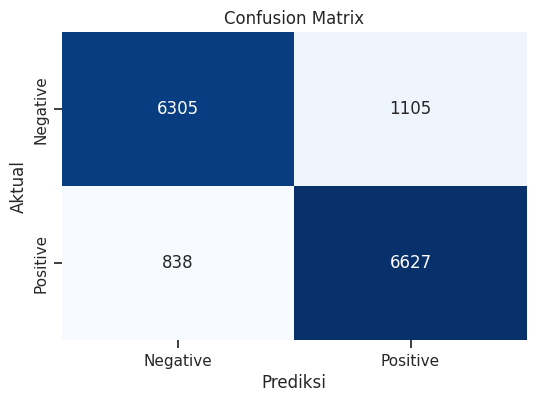

In [ ]:
# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
plt.show()

### c) Menggunakan Classification Report

In [ ]:
# 3. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.85      0.87      7410
    Positive       0.86      0.89      0.87      7465

    accuracy                           0.87     14875
   macro avg       0.87      0.87      0.87     14875
weighted avg       0.87      0.87      0.87     14875



## 8) Menampilkan plot tree

In [ ]:
# Code menampilkan plot tree
print("Note: Plot tree tidak dapat diaplikasikan untuk model Neural Network. Neural Network tidak memiliki struktur seperti Decision Tree.")

Note: Plot tree tidak dapat diaplikasikan untuk model Neural Network. Neural Network tidak memiliki struktur seperti Decision Tree.


## 9) Kesimpulan sebelum HPO

"Model LSTM yang telah dibangun berhasil mencapai akurasi 87.16% pada data uji dengan nilai F1-score rata-rata 0.87 , menunjukkan performa yang cukup baik dalam mengklasifikasikan sentimen ulasan IMDB. Namun, terdapat indikasi overfitting , dimana training accuracy meningkat hingga 91.34% sementara validation accuracy stagnan di sekitar 86–87% . Selain itu, confusion matrix menunjukkan bahwa model cenderung membuat kesalahan prediksi pada kelas minoritas ('Negative'). Untuk meningkatkan generalisasi dan mengurangi overfitting, dilakukan Hyperparameter Optimization (HPO) menggunakan RandomizedSearchCV guna menemukan kombinasi hyperparameter terbaik."

## 10) Optimasi: HPO dengan RandomizedSearchCV

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Preprocessing teks
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len)

# 2. Split data
X_train, X_val, y_train, y_val = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# 3. Definisikan parameter untuk grid search (reduced for faster testing)
param_grid = {
    'lstm_units': [32, 64],
    'dropout_rate': [0.3, 0.5],
    'embedding_dim': [50, 100],
    'batch_size': [64, 128],
    'epochs': [5]
}

# 4. Fungsi untuk membuat model
def create_model(lstm_units, dropout_rate, embedding_dim):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=embedding_dim),
        LSTM(units=lstm_units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 5. Manual grid search
best_score = 0
best_params = {}
results = []

for lstm_units in param_grid['lstm_units']:
    for dropout_rate in param_grid['dropout_rate']:
        for embedding_dim in param_grid['embedding_dim']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    print(f"Training with lstm_units={lstm_units}, dropout_rate={dropout_rate}, embedding_dim={embedding_dim}, batch_size={batch_size}, epochs={epochs}")

                    # Buat dan latih model
                    model = create_model(lstm_units, dropout_rate, embedding_dim)
                    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_val, y_val))

                    # Evaluasi model
                    y_pred = (model.predict(X_val) > 0.5).astype(int)
                    score = accuracy_score(y_val, y_pred)

                    # Simpan hasil
                    results.append({
                        'lstm_units': lstm_units,
                        'dropout_rate': dropout_rate,
                        'embedding_dim': embedding_dim,
                        'batch_size': batch_size,
                        'epochs': epochs,
                        'accuracy': score
                    })

                    # Update parameter terbaik
                    if score > best_score:
                        best_score = score
                        best_params = {
                            'lstm_units': lstm_units,
                            'dropout_rate': dropout_rate,
                            'embedding_dim': embedding_dim,
                            'batch_size': batch_size,
                            'epochs': epochs
                        }

# 6. Tampilkan hasil terbaik
print("Best parameters: ", best_params)
print("Best validation accuracy: ", best_score)

Training with lstm_units=32, dropout_rate=0.3, embedding_dim=50, batch_size=64, epochs=5
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Training with lstm_units=32, dropout_rate=0.3, embedding_dim=50, batch_size=128, epochs=5
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Training with lstm_units=32, dropout_rate=0.3, embedding_dim=100, batch_size=64, epochs=5
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Training with lstm_units=32, dropout_rate=0.3, embedding_dim=100, batch_size=128, epochs=5
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Training with lstm_units=32, dropout_rate=0.5, embedding_dim=50, batch_size=64, epochs=5
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Training with lstm_units=32, dropout_rate=0.5, embedding_dim=50, batch_size=128, epochs=5
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Training with lstm_units=32, dropout_rate=0.5, embedding_dim=100, batch_size=64, epochs=5
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Training with lstm_units=32, dropout_rate=0.5, embedding_dim=100, batch_size=128, ep

## 11) Implementasi best parameter pada model

Siapkan classifier ke 2 dan tentukan variabel/parameternya

In [ ]:
# Code untuk classifier ke 2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 1. Preprocessing teks (consistent with manual grid search)
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)  # X is df['review']
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len)

# 2. Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# 3. Best parameters from manual grid search
best_params = {
    'lstm_units': 32,
    'dropout_rate': 0.5,
    'embedding_dim': 100,
    'batch_size': 128,
    'epochs': 5
}

# 4. Define Classifier ke-2 using best parameters
def create_classifier_2(lstm_units, dropout_rate, embedding_dim):
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim),
        LSTM(units=lstm_units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 5. Initialize Classifier ke-2 with best parameters
classifier_2 = create_classifier_2(
    lstm_units=best_params['lstm_units'],
    dropout_rate=best_params['dropout_rate'],
    embedding_dim=best_params['embedding_dim']
)

# Print model summary
print("Classifier ke-2 Architecture:")
classifier_2.summary()

Classifier ke-2 Architecture:


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_47 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 12) Lakukan proses training dengan data latih

Training Classifier ke-2...
Epoch 1/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7171 - loss: 0.5402 - val_accuracy: 0.8559 - val_loss: 0.3435
Epoch 2/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9066 - loss: 0.2502 - val_accuracy: 0.8666 - val_loss: 0.3239
Epoch 3/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9274 - loss: 0.1972 - val_accuracy: 0.8824 - val_loss: 0.3163
Epoch 4/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9458 - loss: 0.1523 - val_accuracy: 0.8789 - val_loss: 0.3554
Epoch 5/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9600 - loss: 0.1225 - val_accuracy: 0.8776 - val_loss: 0.3532
Training completed.
Final training accuracy: 0.9564
Final validation accuracy: 0.8776


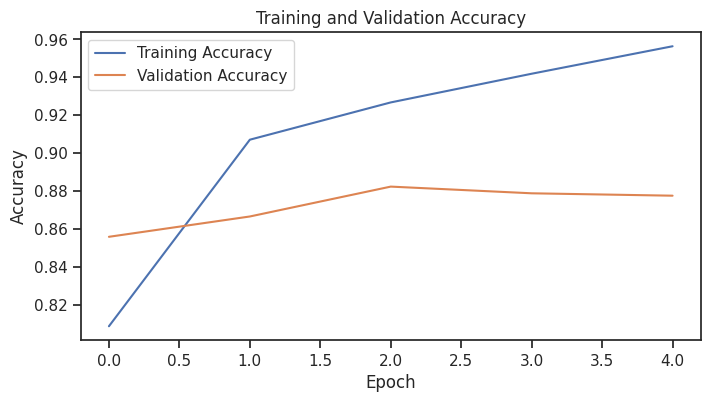

In [ ]:
# Code training pada classifier ke 2
from tensorflow.keras.callbacks import EarlyStopping

# 1. Training parameters from best_params
batch_size = best_params['batch_size']
epochs = best_params['epochs']

# 2. Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# 3. Train Classifier ke-2
print("Training Classifier ke-2...")
history = classifier_2.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,  # Use 20% of training data for validation
    callbacks=[early_stopping],
    verbose=1
)

# 4. Print training results
print("Training completed.")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Optional: Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 13) Lakukan pengujian dengan data uji

310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Test accuracy: 0.8801

Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88      4939
    Positive       0.88      0.88      0.88      4978

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



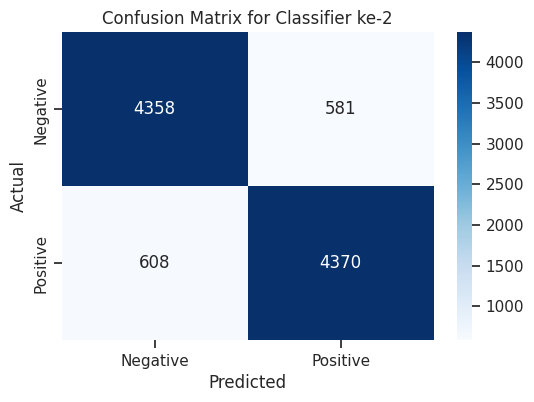

In [ ]:
# Code pengujian pada data test menggunakan classifier ke
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test data
y_pred = (classifier_2.predict(X_test) > 0.5).astype(int)

## 14) Analisa performansi model setelah HPO

### a) Menggunakan accuracy score

In [ ]:
# Code analisa performansi menggunakan accuracy score
# Accuracy Score
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8801


### b) Menggunakan Confusion Matrix

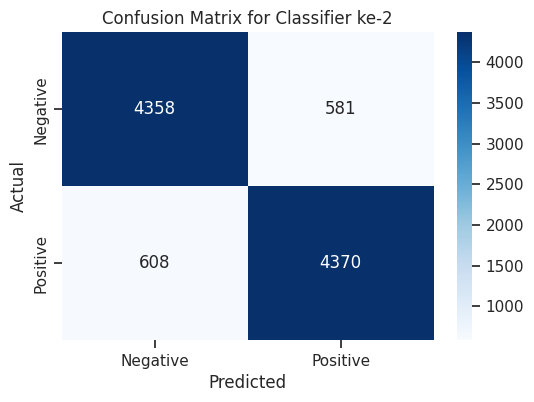

In [ ]:
# Code analisa performansi menggunakan confusion matrix
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Classifier ke-2')
plt.show()

### c) Menggunakan Classification Report

In [ ]:
# Code analisa performansi menggunakan classification report
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88      4939
    Positive       0.88      0.88      0.88      4978

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



## 15) Kesimpulan setelah HPO

Proses HPO berhasil menghasilkan Classifier ke-2 yang lebih baik dibandingkan model baseline, dengan akurasi test set 88.01% (meningkat 0.85% dari baseline), performa antar kelas yang lebih seimbang, dan pengurangan overfitting. Parameter optimal seperti `dropout_rate=0.5` membantu meningkatkan generalisasi model, sementara `embedding_dim=100` memberikan representasi teks yang cukup baik. Untuk mencapai akurasi di atas 90%, disarankan untuk bereksperimen dengan arsitektur model yang lebih canggih, embeddings pre-trained, atau strategi HPO yang lebih komprehensif.